# Import libraries

In [1]:
import os
import subprocess
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

2024-09-16 20:42:38.538267: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 20:42:38.540668: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 20:42:38.548174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 20:42:38.564855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 20:42:38.564888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 20:42:38.575316: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
# Function to pair SNPs and summarize genotype
def summarize_genotypes(df):
    summarized_genotypes = {}
    # Iterate over pairs of columns
    for i in range(1, df.shape[1], 2):
        pair_sum = df.iloc[:, i-1] + df.iloc[:, i]
        # Apply the genotype summarization logic
        summarized_genotypes[f'G{i//2 + 1}'] = np.where(pair_sum == 2, 2, pair_sum)
    return pd.DataFrame(summarized_genotypes)

# Function to flip 0s to 2s and 2s to 0s
def flip_genotypes(row):
    if row['AFs'] > 0.5:
        # Apply transformation for the condition
        row[:-1] = row[:-1].replace({0: 2, 2: 0})
        row['AFs'] = 1 - row['AFs']  # Adjust allele frequency
    return row

def contains_all_genotypes(series, genotypes={0.0, 1.0, 2.0}):
    return genotypes.issubset(series.unique())

In [3]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [4]:
dict = parse_variables('geno_simulation.txt')
G = 10
L = 100
c = 50
k = 2
M = .1
HWE = 1

# Define the R commands to run, passing parameters as arguments
commands = [
    f"source('geno_simulation.txt')",
    f"source('create_geno.R', echo=TRUE)",
]


commands = [
    "source('geno_simulation.txt')",
    f"G <- {G}",
    f"L <- {L}",
    f"c <- {c}",
    f"k <- {k}",
    f"M <- {M}",
    "source('create_geno.R', echo=TRUE)"
]

# Concatenate commands into a single string
r_script = ";".join(commands)

# Run the R script
result = subprocess.run(['Rscript', '-e', r_script], capture_output=True, text=True)

# Print the output
#print(result.stdout)

# Check for errors
if result.returncode != 0:
    print("Error executing R script:")
    print(result.stderr)
    pass

os.makedirs(f"data/concept/genotype/raw",exist_ok=True)
os.system(f"mv simulated_genotypes_G{G}_L{L}_c{c}_k{k}_M{M}.csv data/concept/genotype/raw/")

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

file = f"data/concept/genotype/raw/simulated_genotypes_G{G}_L{L}_c{c}_k{k}_M{M}.csv"
path_simulated_file = "./"+ file
number_of_loci = G*L
number_of_individuals = c*k*k
simulated_loci= pd.read_csv(path_simulated_file)

In [5]:
# Apply the function to the sample DataFrame
simulated_genotype = summarize_genotypes(simulated_loci)
columns_to_drop  = simulated_genotype.columns[simulated_genotype.nunique() == 1] # If double columns delete it 
simulated_genotype = simulated_genotype.drop(columns=columns_to_drop)

In [6]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

simulated_genotype["populations"] = labels_pop
simulated_genotype['populations'] = simulated_genotype['populations'].apply(lambda x: 1 if x in [1, 2] else 2)

In [7]:
unique_pops = simulated_genotype['populations'].unique()
unique_pops.sort()
dfs = []
required_values = {0, 1, 2}

# Optimization: Cache the set operation result
simulated_genotype_sets = {col: set(simulated_genotype[col]) for col in simulated_genotype.columns}

if HWE == 1:
    for pop in unique_pops:
        temp_pop = simulated_genotype[simulated_genotype["populations"] == pop].drop('populations', axis=1)
        
        for col in temp_pop.columns:
            column_values = simulated_genotype_sets[col]
            
            if not required_values.issubset(column_values):
                # Optimization: Vectorized random choice and assignment
                indices = np.random.choice(temp_pop.index, size=3, replace=False)
                temp_pop.loc[indices[0], col] = 0
                temp_pop.loc[indices[1], col] = 1
                temp_pop.loc[indices[2], col] = 2

            # Calculate frequencies
            value_counts = temp_pop[col].value_counts().reindex([0, 1, 2], fill_value=0)
            total = value_counts.sum()
            q = (2*value_counts[2] + value_counts[1])/ (2*total)
            if q > 0.5:
                q = 1-q
            p = 1 - q
            freq_maj = p ** 2
            freq_het = 2 * p * q
            freq_min = q ** 2

            # Optimization: Vectorized assignment of new genotypes
            pop_geno = np.random.choice([1.0, 0.0, -1.0], size=total, p=[freq_maj, freq_het, freq_min])
            temp_pop[col] = pop_geno

        dfs.append(temp_pop)

else:
    print("HWE")
    for pop in unique_pops:
        temp_pop = simulated_genotype[simulated_genotype["populations"] == pop].drop('populations', axis=1)
        
        for col in temp_pop.columns:
            column_values = simulated_genotype_sets[col]
            
            if not required_values.issubset(column_values):
                # Optimization: Vectorized random choice and assignment
                indices = np.random.choice(temp_pop.index, size=3, replace=False)
                temp_pop.loc[indices[0], col] = 0
                temp_pop.loc[indices[1], col] = 1
                temp_pop.loc[indices[2], col] = 2

            # Calculate frequencies
            value_counts = temp_pop[col].value_counts().reindex([0, 1, 2], fill_value=0)
            total = value_counts.sum()
            q = (2*value_counts[2] + value_counts[1])/ (2*total)
            if q > 0.5:
                q = 1-q
            p = 1 - q
            freq_maj = p ** 2
            freq_het = q ** 2
            freq_min = 2 * p * q

            # Optimization: Vectorized assignment of new genotypes
            pop_geno = np.random.choice([1.0, 0.0, -1.0], size=total, p=[freq_maj, freq_het, freq_min])
            temp_pop[col] = pop_geno

        dfs.append(temp_pop)

# Concatenate all dataframes if needed
simulated_genotype = pd.concat(dfs, ignore_index=True)

In [8]:
simulated_genotype = simulated_genotype+1

In [9]:
# calculate when AF is > 0.5 and change the genotype
# Initialize a dictionary to store allele frequencies
allele_frequencies = {}

# Calculate allele frequencies for each SNP column
for snp in simulated_genotype.columns:
    total_alleles = 2 * len(simulated_genotype[snp])  # Total number of alleles (2 alleles per sample)
    minor_allele_count = (2 * simulated_genotype[snp].value_counts().get(0, 0)) + simulated_genotype[snp].value_counts().get(1, 0)
    allele_frequency = minor_allele_count / total_alleles
    allele_frequencies[snp] = allele_frequency

In [10]:
temp = simulated_genotype.T
temp['AFs'] = allele_frequencies

In [11]:
# Apply the function across the DataFrame, row-wise
df_transformed = temp.apply(flip_genotypes, axis=1)

In [12]:
simulated_genotype = df_transformed.drop('AFs', axis=1).T
columns_to_drop  = simulated_genotype.columns[simulated_genotype.nunique() == 1] # If double columns delete it 
simulated_genotype = simulated_genotype.drop(columns=columns_to_drop)

In [13]:
simulated_genotype = simulated_genotype[[col for col in simulated_genotype.columns if contains_all_genotypes(simulated_genotype[col])]]

In [14]:
# calculate when AF is > 0.5 and change the genotype
# Initialize a dictionary to store allele frequencies
allele_frequencies = {}

# Calculate allele frequencies for each SNP column
for snp in simulated_genotype.columns:
    total_alleles = 2 * len(simulated_genotype[snp])  # Total number of alleles (2 alleles per sample)
    minor_allele_count = (2 * simulated_genotype[snp].value_counts().get(0, 0)) + simulated_genotype[snp].value_counts().get(1, 0)
    allele_frequency = minor_allele_count / total_alleles
    allele_frequencies[snp] = allele_frequency

In [15]:
temp = simulated_genotype.T
temp['AFs'] = allele_frequencies
AFs = temp[['AFs']]

In [16]:
# Create slices as copies to avoid SettingWithCopyWarning
very_rare = temp[(temp['AFs'] > very_rare_threshold_L) & (temp['AFs'] <= very_rare_threshold_H)].copy()
rare = temp[(temp['AFs'] > rare_threshold_L) & (temp['AFs'] <= rare_threshold_H)].copy()
common = temp[(temp['AFs'] > common_threshold_L) & (temp['AFs'] <= common_threshold_H)].copy()

# Modify 'snps' column using .loc to avoid warnings
very_rare.loc[:, 'snps'] = very_rare.index + '_AF_' + very_rare['AFs'].astype(str)
very_rare.set_index('snps', inplace=True)
very_rare_to_save = very_rare.drop('AFs', axis=1).T
very_rare_afs = very_rare[['AFs']]

rare.loc[:, 'snps'] = rare.index + '_AF_' + rare['AFs'].astype(str)
rare.set_index('snps', inplace=True)
rare_to_save = rare.drop('AFs', axis=1).T
rare_afs = rare[['AFs']]

common.loc[:, 'snps'] = common.index + '_AF_' + common['AFs'].astype(str)
common.set_index('snps', inplace=True)
common_to_save = common.drop('AFs', axis=1).T
common_afs = common[['AFs']]

In [17]:
very_rare_to_save = very_rare_to_save.rename(columns=lambda x: 'VR' + x)/2
rare_to_save = rare_to_save.rename(columns=lambda x: 'R' + x)/2
common_to_save = common_to_save.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common_to_save, rare_to_save, very_rare_to_save], axis=1)
complete = ((complete*2)-1)

In [18]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

simulated_genotype["populations"] = labels_pop
simulated_genotype['populations'] = simulated_genotype['populations'].apply(lambda x: 1 if x in [1, 2] else 2)

In [19]:
complete['pop'] = simulated_genotype['populations']

p2s_dfs = []
q2s_dfs = []
twopqs_dfs = []

for pop in complete['pop'].unique():
    temp = complete[complete['pop'] == pop].drop("pop", axis=1)

    # Count the number of major, heterozygous, and minor alleles
    counts = temp.apply(pd.Series.value_counts).fillna(0)

    num_maj = counts.loc[1.0]
    num_het = counts.loc[0.0]
    num_min = counts.loc[-1.0]

    total_humans = num_maj + num_het + num_min

    # Normalize to get frequencies instead of counts
    p2s = num_maj / total_humans
    twopqs = num_het / total_humans
    q2s = num_min / total_humans

    # Expand the normalized values across all rows for each population
    p2s_dfs.append(pd.DataFrame([p2s] * temp.shape[0], index=temp.index, columns=temp.columns))
    twopqs_dfs.append(pd.DataFrame([twopqs] * temp.shape[0], index=temp.index, columns=temp.columns))
    q2s_dfs.append(pd.DataFrame([q2s] * temp.shape[0], index=temp.index, columns=temp.columns))

# Drop "pop" from the original DataFrame
complete = complete.drop("pop", axis=1)

# Concatenate all population-specific DataFrames
true_p2s = pd.concat(p2s_dfs)
true_twopqs = pd.concat(twopqs_dfs)
true_q2s = pd.concat(q2s_dfs)

In [20]:
count_total_AFs = complete.apply(pd.Series.value_counts).fillna(0)/number_of_individuals

In [21]:
count_total_AFs

snps,CG1_AF_0.355,CG3_AF_0.2625,CG5_AF_0.2875,CG6_AF_0.2225,CG11_AF_0.2625,CG12_AF_0.2525,CG16_AF_0.38,CG20_AF_0.2375,CG24_AF_0.25,CG25_AF_0.2475,...,VRG54_AF_0.0425,VRG125_AF_0.0475,VRG181_AF_0.045,VRG280_AF_0.0425,VRG345_AF_0.03,VRG401_AF_0.04,VRG407_AF_0.0475,VRG434_AF_0.035,VRG435_AF_0.045,VRG439_AF_0.05
-1.0,0.14,0.120,0.115,0.080,0.120,0.105,0.165,0.095,0.11,0.095,...,0.010,0.005,0.01,0.005,0.005,0.005,0.005,0.005,0.005,0.005
0.0,0.43,0.285,0.345,0.285,0.285,0.295,0.430,0.285,0.28,0.305,...,0.065,0.085,0.07,0.075,0.050,0.070,0.085,0.060,0.080,0.090
1.0,0.43,0.595,0.540,0.635,0.595,0.600,0.405,0.620,0.61,0.600,...,0.925,0.910,0.92,0.920,0.945,0.925,0.910,0.935,0.915,0.905


In [22]:
first_snp = list(complete.columns)[0]

In [23]:
geno = complete[[first_snp]]

In [24]:
p2_min_q2 = true_p2s - true_q2s
p2_min_q2 = p2_min_q2[[first_snp]]

In [25]:
populations = simulated_genotype[['populations']]

In [26]:

populations['x'] = populations['populations']
populations['y'] = 1
populations['z'] = 0.5

In [27]:
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

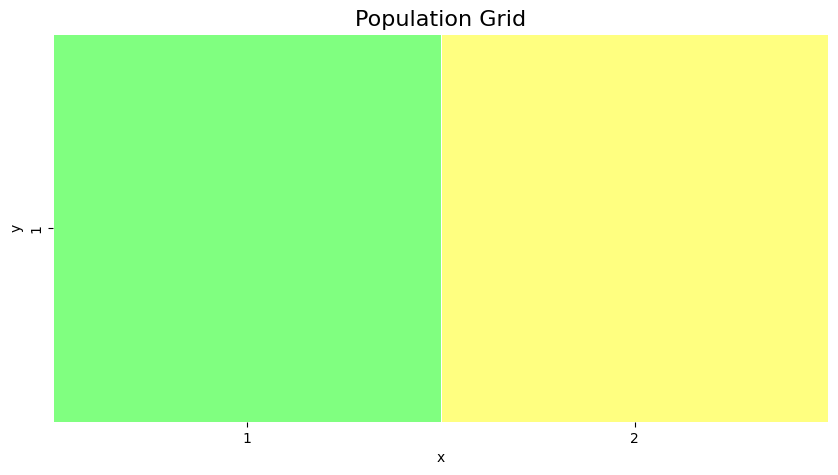

In [28]:
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'populations': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='populations')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

In [29]:
scaler = StandardScaler()
scaled_complete = scaler.fit_transform(complete)
n_components = max(min(complete.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_complete = pca.fit_transform(scaled_complete)
PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

In [30]:
to_have_collumns = ['populations', 'x', 'y']
PC_complete[to_have_collumns] = populations[to_have_collumns]

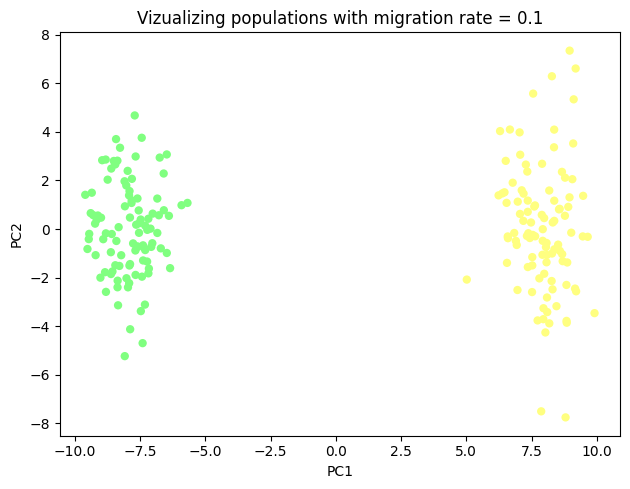

In [31]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [32]:
PC_complete['mafs'] = true_q2s[[first_snp]].apply(np.sqrt).round(2)

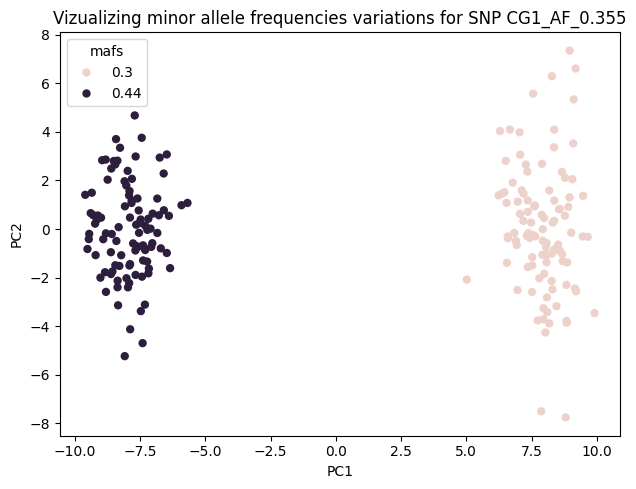

In [33]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'mafs', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing minor allele frequencies variations for SNP {first_snp}")
plt.show()
plt.close()

In [34]:
risk = existing_risks[1]
risk

'NW_risk_fun'

In [35]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)


In [36]:
risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
populations['x_temp'] = populations['x']/k
populations['y_temp'] = populations['y']/k
populations[name_risk] = list(populations.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
populations[name_risk] = populations[name_risk].astype('float')

In [37]:
PC_complete['risk'] = populations['NW_risk']

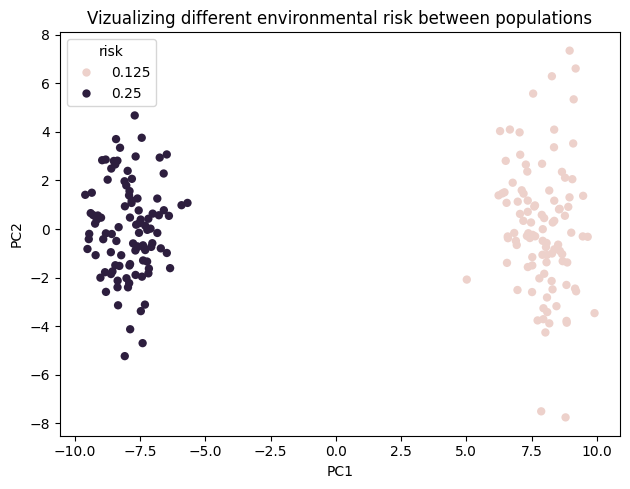

In [38]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'risk', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different environmental risk between populations")
plt.show()
plt.close()

In [39]:
# manually calculate the betas 

In [40]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler = StandardScaler()
PC_complete['risk_scaled'] = scaler.fit_transform(PC_complete[['risk']])

In [41]:
PC_complete['snp'] = complete[first_snp]
mean_risk_per_pop = {}
nr_people_per_pop = {}
maj_afs = {}
min_afs = {}
het_afs = {}
total_nr_peeps = 0
mean_global_risk = 0
for unique_pop in PC_complete.populations.unique():
    temp = PC_complete[PC_complete['populations'] == unique_pop]


    total_alleles = len(temp['snp'])  # Total number of alleles (2 alleles per sample)
    q2_freq = (temp['snp'].value_counts().get(-1, 0))/total_alleles
    pq_freq = (temp['snp'].value_counts().get(0, 0))/total_alleles
    p2_freq = (temp['snp'].value_counts().get(1, 0))/total_alleles

    
    mean_risk_per_pop[unique_pop] = temp['risk_scaled'].mean()
    mean_global_risk += temp['risk_scaled'].mean()
    nr_people_per_pop[unique_pop] = len(temp)
    total_nr_peeps += len(temp)
    maj_afs[unique_pop] = p2_freq
    min_afs[unique_pop] = q2_freq
    het_afs[unique_pop] = pq_freq

mean_risk_per_pop['global_mean'] = mean_global_risk/len(PC_complete.populations.unique())
nr_people_per_pop['total'] = total_nr_peeps

total_alleles = len(PC_complete['snp'])  # Total number of alleles (2 alleles per sample)
q2_freq = (PC_complete['snp'].value_counts().get(-1, 0))/total_alleles
pq_freq = (PC_complete['snp'].value_counts().get(0, 0))/total_alleles
p2_freq = (PC_complete['snp'].value_counts().get(1, 0))/total_alleles

maj_afs['mean'] = p2_freq
min_afs['mean'] = q2_freq
het_afs['mean'] = pq_freq


In [42]:
mean_risk_per_pop

{1: 1.0, 2: -1.0, 'global_mean': 0.0}

In [43]:
nr_people_per_pop

{1: 100, 2: 100, 'total': 200}

In [44]:
maj_afs

{1: 0.29, 2: 0.57, 'mean': 0.43}

In [45]:
min_afs

{1: 0.19, 2: 0.09, 'mean': 0.14}

In [46]:
het_afs

{1: 0.52, 2: 0.34, 'mean': 0.43}

In [47]:
pheno_minor_pop1 = (nr_people_per_pop[1]/nr_people_per_pop['total'])*(min_afs[1])*mean_risk_per_pop[1]
pheno_minor_pop2 = (nr_people_per_pop[2]/nr_people_per_pop['total'])*(min_afs[2]/min_afs['mean'])*mean_risk_per_pop[2]

In [48]:
pheno_minor = pheno_minor_pop1+pheno_minor_pop2
pheno_minor

-0.2264285714285714

In [49]:
pheno_het_pop1 = (nr_people_per_pop[1]/nr_people_per_pop['total'])*(het_afs[1])*mean_risk_per_pop[1]
pheno_het_pop2 = (nr_people_per_pop[2]/nr_people_per_pop['total'])*(het_afs[2]/het_afs['mean'])*mean_risk_per_pop[2]
pheno_het = pheno_het_pop1+pheno_het_pop2
pheno_het

-0.13534883720930235

In [50]:
pheno_maj_pop1 = (nr_people_per_pop[1]/nr_people_per_pop['total'])*(maj_afs[1])*mean_risk_per_pop[1]
pheno_maj_pop2 = (nr_people_per_pop[2]/nr_people_per_pop['total'])*(maj_afs[2]/maj_afs['mean'])*mean_risk_per_pop[2]
pheno_maj = pheno_maj_pop1+pheno_maj_pop2
pheno_maj

-0.5177906976744185

In [51]:
geno_minor = -1
geno_het = 0
geno_major = 1

In [52]:
sum_x = geno_minor + geno_het + geno_major
sum_y = pheno_minor + pheno_het + pheno_maj
sum_xy = geno_minor*pheno_minor + geno_het*pheno_het + geno_major*pheno_maj
sum_x2 = geno_minor**2 + geno_het**2 + geno_minor**2

In [53]:
(3*sum_xy-sum_x*sum_y)/(3*sum_x2 - sum_x**2)

-0.14568106312292356

In [54]:
only_risk_via_snps = manhattan_linear(complete[[first_snp]], PC_complete[['risk_scaled']])
only_risk_via_snps

,snp,coefs,AFs,Ps,-logPs
0,CG1,-0.333333,0.355,0.000314,3.503688


In [55]:
only_risk_via_snps = manhattan_linear(p2_min_q2[[first_snp]]*6, PC_complete[['risk_scaled']])
only_risk_via_snps

,snp,coefs,AFs,Ps,-logPs
0,CG1,-0.26345,0.355,3.758172e-17,16.425023


In [56]:
count_total_AFs

snps,CG1_AF_0.355,CG3_AF_0.2625,CG5_AF_0.2875,CG6_AF_0.2225,CG11_AF_0.2625,CG12_AF_0.2525,CG16_AF_0.38,CG20_AF_0.2375,CG24_AF_0.25,CG25_AF_0.2475,...,VRG54_AF_0.0425,VRG125_AF_0.0475,VRG181_AF_0.045,VRG280_AF_0.0425,VRG345_AF_0.03,VRG401_AF_0.04,VRG407_AF_0.0475,VRG434_AF_0.035,VRG435_AF_0.045,VRG439_AF_0.05
-1.0,0.14,0.120,0.115,0.080,0.120,0.105,0.165,0.095,0.11,0.095,...,0.010,0.005,0.01,0.005,0.005,0.005,0.005,0.005,0.005,0.005
0.0,0.43,0.285,0.345,0.285,0.285,0.295,0.430,0.285,0.28,0.305,...,0.065,0.085,0.07,0.075,0.050,0.070,0.085,0.060,0.080,0.090
1.0,0.43,0.595,0.540,0.635,0.595,0.600,0.405,0.620,0.61,0.600,...,0.925,0.910,0.92,0.920,0.945,0.925,0.910,0.935,0.915,0.905


In [57]:
count_total_AFs.loc[1.0]

snps
CG1_AF_0.355        0.430
CG3_AF_0.2625       0.595
CG5_AF_0.2875       0.540
CG6_AF_0.2225       0.635
CG11_AF_0.2625      0.595
                    ...  
VRG401_AF_0.04      0.925
VRG407_AF_0.0475    0.910
VRG434_AF_0.035     0.935
VRG435_AF_0.045     0.915
VRG439_AF_0.05      0.905
Name: 1.0, Length: 429, dtype: float64

In [58]:
true_p2s_ols = true_p2s**2
true_p2s_ols = true_p2s_ols.div(count_total_AFs.loc[1.0], axis=1)

true_q2s_ols = true_q2s**2
true_q2s_ols = true_q2s_ols.div(count_total_AFs.loc[-1.0], axis=1)

In [59]:
p2_min_q2 = true_p2s_ols - true_q2s_ols

In [60]:
one_over_p2_min_q2 = 1/p2_min_q2
max_value = one_over_p2_min_q2.replace([np.inf, -np.inf], np.nan).max().max()
one_over_p2_min_q2.replace([np.inf, -np.inf], max_value, inplace=True)

In [77]:
def manual_ols(X,y):
    X = np.array(complete[[first_snp]])
    #X = np.column_stack([np.ones(len(X)), X])
    beta_matrix = np.linalg.inv(X.T @ X)
    y = np.array(y).reshape(-1, 1)  # Reshape to 2D column vector
    beta_matrix = (beta_matrix @ X.T) @ y
    return beta_matrix[0][0]

In [61]:
betas_calculated = []
betas_test = []
betas_snps = []
betas_mafs = []

P_val_snps = []
P_val_mafs = []
for first_snp in complete.columns:
    PC_complete['snp'] = complete[first_snp]
    mean_risk_per_pop = {}
    nr_people_per_pop = {}
    maj_afs = {}
    min_afs = {}
    het_afs = {}
    total_nr_peeps = 0
    mean_global_risk = 0
    for unique_pop in PC_complete.populations.unique():
        temp = PC_complete[PC_complete['populations'] == unique_pop]
    
    
        total_alleles = len(temp['snp'])  # Total number of alleles (2 alleles per sample)
        q2_freq = (temp['snp'].value_counts().get(-1, 0))/total_alleles
        pq_freq = (temp['snp'].value_counts().get(0, 0))/total_alleles
        p2_freq = (temp['snp'].value_counts().get(1, 0))/total_alleles
    
        
        mean_risk_per_pop[unique_pop] = temp['risk_scaled'].mean()
        mean_global_risk += temp['risk_scaled'].mean()
        nr_people_per_pop[unique_pop] = len(temp)
        total_nr_peeps += len(temp)
        maj_afs[unique_pop] = p2_freq
        min_afs[unique_pop] = q2_freq
        het_afs[unique_pop] = pq_freq
    
    mean_risk_per_pop['global_mean'] = mean_global_risk/len(PC_complete.populations.unique())
    nr_people_per_pop['total'] = total_nr_peeps
    
    total_alleles = len(PC_complete['snp'])  # Total number of alleles (2 alleles per sample)
    q2_freq = (PC_complete['snp'].value_counts().get(-1, 0))/total_alleles
    pq_freq = (PC_complete['snp'].value_counts().get(0, 0))/total_alleles
    p2_freq = (PC_complete['snp'].value_counts().get(1, 0))/total_alleles
    
    maj_afs['mean'] = p2_freq
    min_afs['mean'] = q2_freq
    het_afs['mean'] = pq_freq

    pheno_minor = 0
    pheno_het = 0
    pheno_major = 0
    ns = 0
    for unique_pop in PC_complete.populations.unique():
        pheno_minor += (nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total'])*(min_afs[unique_pop]**2/min_afs['mean'])*(mean_risk_per_pop[unique_pop])
        pheno_het += (nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total'])*(het_afs[unique_pop]**2/het_afs['mean'])*(mean_risk_per_pop[unique_pop])
        pheno_major += (nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total'])*(maj_afs[unique_pop]**2/maj_afs['mean'])*(mean_risk_per_pop[unique_pop])
        ns  += 3
    
    geno_minor = -1
    geno_het = 0
    geno_major = 1

    sum_x = geno_minor + geno_het + geno_major
    sum_y = pheno_minor + pheno_het + pheno_maj
    sum_xy = geno_minor*pheno_minor + geno_het*pheno_het + geno_major*pheno_maj
    sum_x2 = geno_minor**2 + geno_het**2 + geno_minor**2

    beta_calculated = (ns*sum_xy-sum_x*sum_y)/(ns*sum_x2 - sum_x**2)
    betas_calculated.append(beta_calculated)
    beta_snps = manhattan_linear(complete[[first_snp]], PC_complete[['risk_scaled']])
    betas_snps.append(beta_snps['coefs'][0])
    P_val_snps.append(beta_snps['-logPs'][0])

    beta_maf = manhattan_linear(one_over_p2_min_q2[[first_snp]], PC_complete[['risk_scaled']])
    betas_mafs.append(beta_maf['coefs'][0])
    P_val_mafs.append(beta_maf['-logPs'][0])
    

In [108]:
betas_calculated = []
betas_snps = []
betas_mafs = []
betas_test = []
P_val_snps = []
P_val_mafs = []
Xs_test = []
Ys_test = []
for first_snp in complete.columns:
    PC_complete['snp'] = complete[first_snp]
    mean_risk_per_pop = {}
    nr_people_per_pop = {}
    maj_afs = {}
    min_afs = {}
    het_afs = {}
    total_nr_peeps = 0
    mean_global_risk = 0
    for unique_pop in PC_complete.populations.unique():
        temp = PC_complete[PC_complete['populations'] == unique_pop]
    
    
        total_alleles = len(temp['snp'])  # Total number of alleles (2 alleles per sample)
        q2_freq = (temp['snp'].value_counts().get(-1, 0))/total_alleles
        pq_freq = (temp['snp'].value_counts().get(0, 0))/total_alleles
        p2_freq = (temp['snp'].value_counts().get(1, 0))/total_alleles
    
        
        mean_risk_per_pop[unique_pop] = temp['risk_scaled'].mean()
        mean_global_risk += temp['risk_scaled'].mean()
        nr_people_per_pop[unique_pop] = len(temp)
        total_nr_peeps += len(temp)
        maj_afs[unique_pop] = p2_freq
        min_afs[unique_pop] = q2_freq
        het_afs[unique_pop] = pq_freq
    
    mean_risk_per_pop['global_mean'] = mean_global_risk/len(PC_complete.populations.unique())
    nr_people_per_pop['total'] = total_nr_peeps
    
    total_alleles = len(PC_complete['snp'])  # Total number of alleles (2 alleles per sample)
    q2_freq = (PC_complete['snp'].value_counts().get(-1, 0))/total_alleles
    pq_freq = (PC_complete['snp'].value_counts().get(0, 0))/total_alleles
    p2_freq = (PC_complete['snp'].value_counts().get(1, 0))/total_alleles
    
    maj_afs['mean'] = p2_freq
    min_afs['mean'] = q2_freq
    het_afs['mean'] = pq_freq

    pheno_minor = 0
    pheno_het = 0
    pheno_major = 0
    ns = 0
    Xs_test = []
    Ys_test = []
    for unique_pop in PC_complete.populations.unique():
        pheno_minor += (nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total'])*(min_afs[unique_pop]**2/min_afs['mean'])*(mean_risk_per_pop[unique_pop])
        Xs_test.append(-1*min_afs[unique_pop]*(nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total']))
        
        pheno_het += (nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total'])*(het_afs[unique_pop]**2/het_afs['mean'])*(mean_risk_per_pop[unique_pop])
        Xs_test.append(0*het_afs[unique_pop]*(nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total']))
        
        pheno_major += (nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total'])*(maj_afs[unique_pop]**2/maj_afs['mean'])*(mean_risk_per_pop[unique_pop])
        Xs_test.append(1*maj_afs[unique_pop]*(nr_people_per_pop[unique_pop]**2/nr_people_per_pop['total']))
        Ys_test.append(mean_risk_per_pop[unique_pop])
        Ys_test.append(mean_risk_per_pop[unique_pop])
        Ys_test.append(mean_risk_per_pop[unique_pop])
        
        ns  += 3
    
    X = np.array((Xs_test-min(Xs_test))/(max(Xs_test)-min(Xs_test))*(1-(-1))+(-1))
    Y = np.array(Ys_test)
    
    n = len(X)
    sum_X = np.sum(X)
    sum_Y = np.sum(Y)
    sum_XY = np.sum(X * Y)
    sum_X_squared = np.sum(X**2)
    betas_test.append((n * sum_XY - sum_X * sum_Y) / (n * sum_X_squared - sum_X**2))
    
    geno_minor = -1
    geno_het = 0
    geno_major = 1

    sum_x = geno_minor + geno_het + geno_major
    sum_y = pheno_minor + pheno_het + pheno_maj
    sum_xy = geno_minor*pheno_minor + geno_het*pheno_het + geno_major*pheno_maj
    sum_x2 = geno_minor**2 + geno_het**2 + geno_minor**2

    beta_calculated = (ns*sum_xy-sum_x*sum_y)/(ns*sum_x2 - sum_x**2)
    betas_calculated.append(beta_calculated)
    beta_snps = manhattan_linear(complete[[first_snp]], PC_complete[['risk_scaled']])
    betas_snps.append(beta_snps['coefs'][0])
    P_val_snps.append(beta_snps['-logPs'][0])

    beta_maf = manhattan_linear(one_over_p2_min_q2[[first_snp]], PC_complete[['risk_scaled']])
    betas_mafs.append(beta_maf['coefs'][0])
    P_val_mafs.append(beta_maf['-logPs'][0])
    

In [109]:
df_mafs = pd.DataFrame()
df_mafs['betas_mafs'] = betas_mafs
df_mafs['-logPs'] = P_val_mafs
df_mafs['betas_snps'] = betas_snps
df_mafs['betas_matrix'] = betas_matrix
df_mafs['betas_calculates'] = betas_calculated
df_mafs['betas_test'] = betas_test


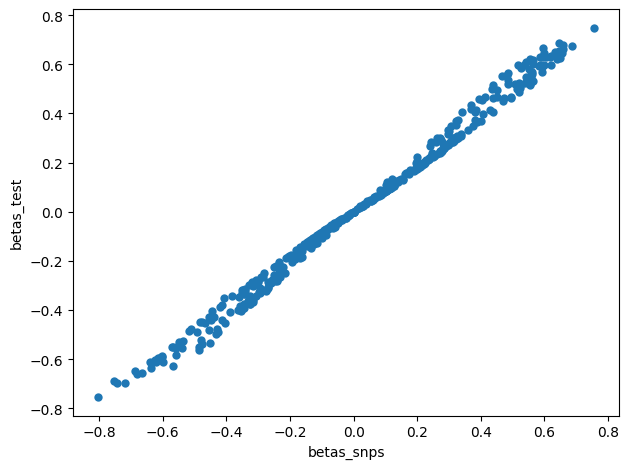

In [110]:
sns.scatterplot(x='betas_snps', y='betas_test',data=df_mafs, linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

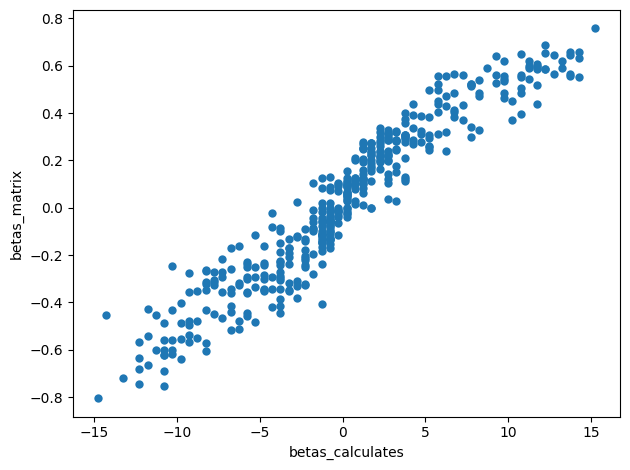

In [100]:
sns.scatterplot(x='betas_calculates', y='betas_matrix',data=df_mafs, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

In [67]:
# lets see what happens when we do a linear regression on this one SNP with different AF per pops

# Now with SNP causality

In [131]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

In [132]:
effectsize = 1
numbers_af = [float(col.split('_AF_')[1]) for col in complete.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in complete.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
betas = pd.DataFrame(data)

In [133]:
all_snps = list(complete.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / 0.001
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)
    std_dev = np.std(phenos_mono[snp])
    mean = np.mean(phenos_mono[snp])
    phenos_mono[snp] = (phenos_mono[snp] - mean) / std_dev

In [134]:
# Beta value first snp

In [135]:
beta_value = betas.loc[betas['snp'] == first_snp.split('_AF_')[0], 'Beta'].values[0]
np.round(beta_value,3)

24.39

In [137]:
phenos_mono

snps,CG2_AF_0.2975,CG5_AF_0.23,CG6_AF_0.305,CG8_AF_0.28,CG10_AF_0.4725,CG12_AF_0.4225,CG13_AF_0.32,CG16_AF_0.2275,CG26_AF_0.3375,CG27_AF_0.24,...,RG495_AF_0.075,RG496_AF_0.11,VRG15_AF_0.04,VRG21_AF_0.0475,VRG53_AF_0.04,VRG201_AF_0.035,VRG275_AF_0.0225,VRG342_AF_0.035,VRG447_AF_0.0075,VRG485_AF_0.04
0,-0.852396,-1.062713,-1.388938,1.073499,1.480618,-0.621430,-0.091221,0.119080,0.844842,-0.740800,...,0.389110,0.141055,-1.350360,1.120960,-1.298121,1.483393,-1.381129,-0.446066,0.142947,0.057342
1,0.168697,-0.986806,0.816898,1.123354,0.559312,1.367614,-0.063547,0.606093,0.656946,-1.232701,...,-0.002904,-0.456979,1.070048,-0.707042,-0.117489,-0.480545,1.059234,0.756620,-1.553490,0.740335
2,-0.768776,-1.760416,1.985724,0.418026,1.067780,-0.196662,-0.022786,-0.560164,-0.819209,0.004359,...,0.956482,-0.318629,2.943193,0.032808,-1.114805,-0.097511,-0.073458,0.192213,-0.371054,1.222918
3,-2.809133,-0.907879,0.583324,-2.052166,-0.675019,-0.679526,-0.324551,0.421616,-0.513938,-0.879292,...,1.847203,0.086299,-0.071544,-1.247431,-0.580115,0.922087,1.887926,-0.769704,0.368734,-1.497483
4,0.079271,-0.048265,0.360823,1.460878,1.451389,1.011309,-1.226265,0.022887,-0.427101,-0.960736,...,0.361952,-0.072553,-0.703635,1.475729,-0.161228,-1.271293,-1.204880,0.299551,-0.637763,-1.931102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.791657,1.833077,-0.336503,0.895747,-0.935256,0.385277,0.813968,0.290473,-0.289664,0.146881,...,0.707981,0.504539,1.126961,0.977003,0.352486,-0.171363,-0.233808,1.721914,-0.345005,-0.803107
196,1.433927,0.160778,-0.219772,-1.305530,-1.039035,-0.262287,0.312991,0.323942,0.441359,-0.168764,...,-1.212542,1.000051,1.765394,-0.224699,-0.079083,0.617324,-0.519857,-1.266762,-1.856868,-1.157544
197,-0.389584,0.031016,0.830640,1.782106,-0.569476,-1.249222,1.056184,0.226393,-0.700946,-0.872154,...,-1.263034,0.876558,-1.416740,-0.906276,0.311028,-0.546535,-0.100043,0.790162,-1.634030,-0.652198
198,-0.363411,1.747806,1.859081,-1.012592,0.560194,-0.136122,0.486451,-0.184203,0.811220,-0.356303,...,-0.276333,2.074490,1.259936,0.325179,-0.701332,-0.243413,0.052930,-0.435292,-1.438338,1.861913


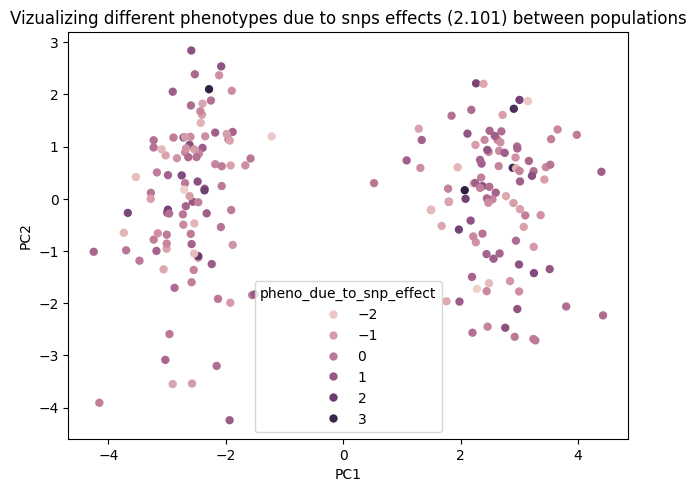

In [59]:
PC_complete['pheno_due_to_snp_effect'] = phenos_mono[[first_snp]]
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'pheno_due_to_snp_effect', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different phenotypes due to snps effects ({np.round(beta_value,3)}) between populations")
plt.show()
plt.close()

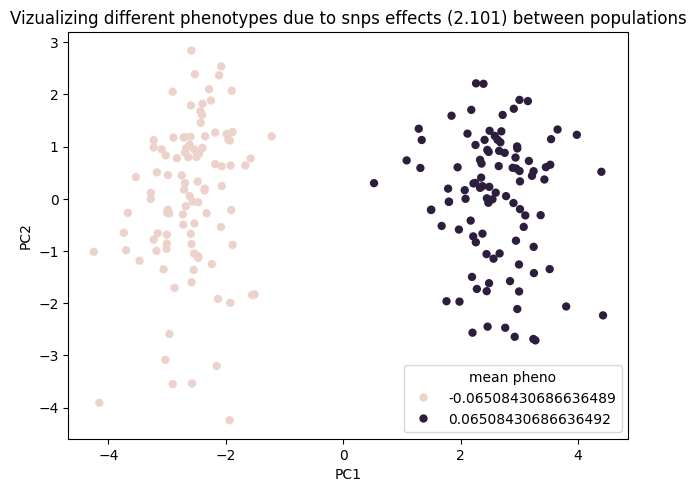

In [60]:
mean_snp_effect_per_pop = PC_complete.groupby('populations')['pheno_due_to_snp_effect'].transform('mean')

# Add the calculated mean as a new column
PC_complete['mean pheno'] = mean_snp_effect_per_pop

sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'mean pheno', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different phenotypes due to snps effects ({np.round(beta_value,3)}) between populations")
plt.show()
plt.close()

In [61]:
to_test = to_test = complete[[first_snp]].copy()

In [62]:
to_test['pheno'] = PC_complete['pheno_due_to_snp_effect']

In [63]:
only_risk_via_snps = manhattan_linear(to_test[[first_snp]], to_test[['pheno']])
only_risk_via_snps 

,snp,coefs,AFs,Ps,-logPs
0,CG3,0.077094,0.475,0.290918,0.536229


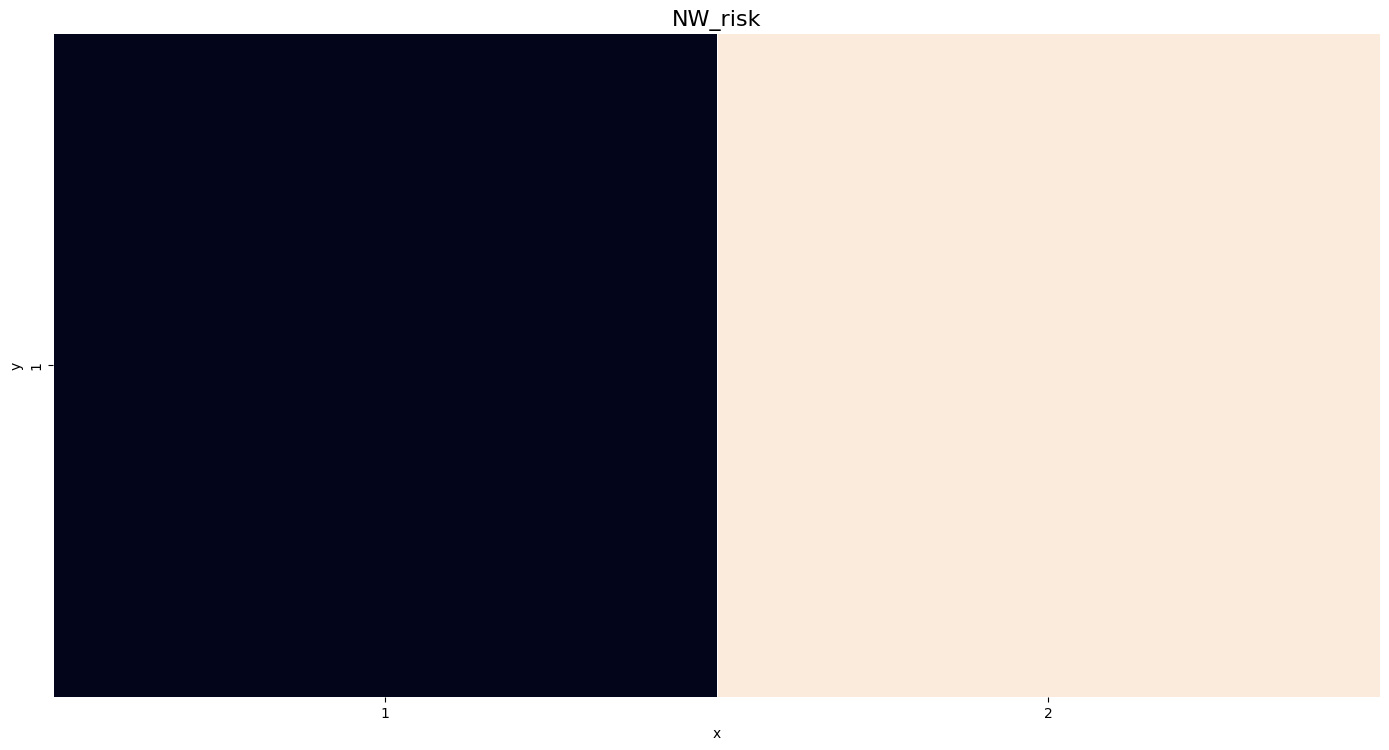

In [64]:
# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Set the title dynamically based on the value of name_risk
axs.set_title(name_risk, fontsize=16)

# Invert the y-axis
axs.invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()